<Figure size 640x480 with 0 Axes>

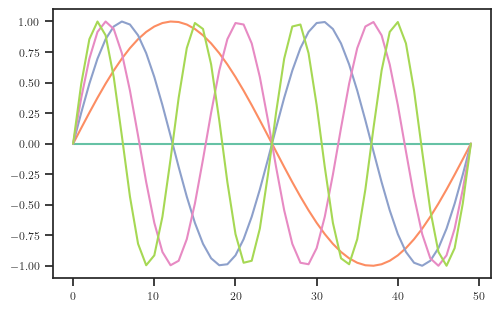

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import path

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

RC_PARAMS = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name, format="pgf"):
    return path.join(FIGURES_PATH, f"{name}.{format}")

#plt.style.use(["default", ])

sns.set_theme(style='ticks', palette='Set2', rc=RC_PARAMS)
sns.despine()

plt.figure(figsize=figsize())
for i in range(5):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()

## Environments

In [2]:
import gym
import gym_search

REPORT_LAYOUT = [
    [0, 0, 0, 1],
    [0, 0, 0, 2],
    [0, 0, 0, 3],
]

SLIDES_LAYOUT = [[0]]

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH

def plot_environment(env_id, seed=0, position=None, layout=REPORT_LAYOUT, width=TEXTWIDTH_IN):
    layout = np.array(layout)
    flattened = layout.flatten()
    unique = set(flattened)
    count = len(unique)
    ratio = layout.shape[0]/layout.shape[1]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=ratio, width=width))
    env = gym.make(env_id)

    for i in range(count):
        env.reset(seed=seed if i == 0 else None)
        env.plot(axs[i], overlay=(i == 0), position=position)

    #fig.tight_layout()

    return fig

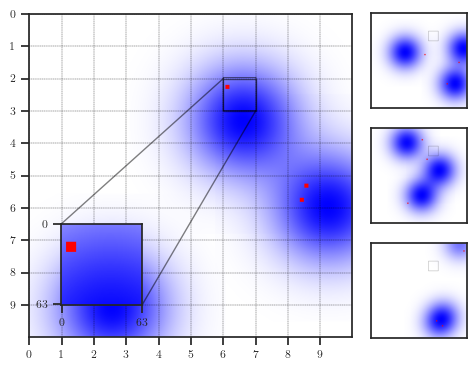

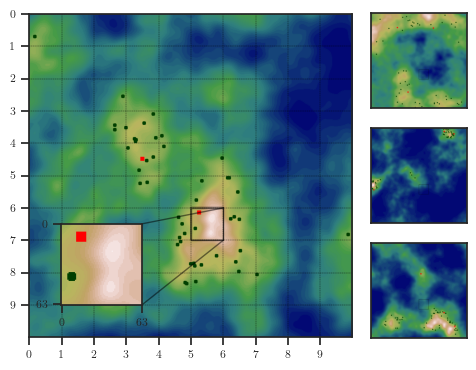

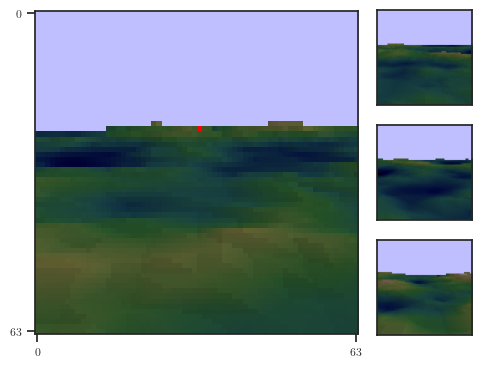

In [32]:
plot_environment("Gaussian-v0", seed=1, layout=REPORT_LAYOUT, position=np.array([2, 6])).savefig(figpath("gaussian", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=REPORT_LAYOUT, position=np.array([6, 5])).savefig(figpath("terrain", format="pgf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=REPORT_LAYOUT, position=np.array([10, 5])).savefig(figpath("camera", format="pgf"), dpi=300, bbox_inches='tight')

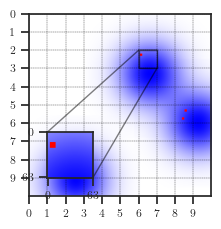

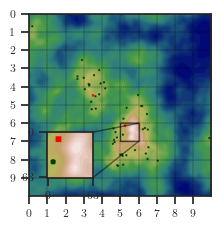

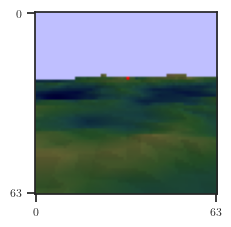

In [31]:
plot_environment("Gaussian-v0", seed=1, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([2, 6])).savefig(figpath("gaussian", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Terrain-v0", seed=6, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([6, 5])).savefig(figpath("terrain", format="pdf"), dpi=300, bbox_inches='tight')
plot_environment("Camera-v0", seed=0, layout=SLIDES_LAYOUT, width=SLIDES_TEXTWIDTH_IN/2, position=np.array([10, 5])).savefig(figpath("camera", format="pdf"), dpi=300, bbox_inches='tight')

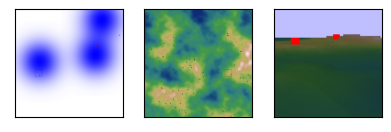

In [13]:
import gym
import gym_search

SLIDES_TEXTWIDTH_IN = 342.2953/PT_PER_INCH
LAYOUT = [[0, 1, 2]]
ENV_IDS = ["Gaussian-v0", "Terrain-v0", "Camera-v0"]
SEEDS = [0, 0, 0]
POSITIONS = [np.array([9, 3]), np.array([9, 12]), np.array([9, 3])]
RATIO = 1.0/len(LAYOUT)

fig, axs = plt.subplot_mosaic(LAYOUT, figsize=figsize(ratio=RATIO, width=SLIDES_TEXTWIDTH_IN))
envs = [gym.make(env_id) for env_id in ENV_IDS]

for i in range(len(ENV_IDS)):
    ax, env, seed, position = axs[i], envs[i], SEEDS[i], POSITIONS[i]
    env.reset(seed=seed)
    env.plot(ax, overlay=False, position=position)

fig.savefig(figpath("environments", format="pdf"), dpi=300, bbox_inches='tight')

## Experiments

In [17]:
import csv

# https://github.com/openai/train-procgen/blob/master/train_procgen

def ema(data_in, smoothing=0):
    data_out = np.zeros_like(data_in)
    curr = np.nan

    for i in range(len(data_in)):
        x = data_in[i]
        if np.isnan(curr):
            curr = x
        else:
            curr = (1 - smoothing) * x + smoothing * curr

        data_out[i] = curr

    return data_out


def plot_data_mean_std(ax, data_y, data_x=None, x_scale=1, smoothing=0, first_valid=0, label=None):
    data_y = data_y[:,first_valid:]
    nx, num_datapoint = np.shape(data_y)

    if smoothing > 0:
        for i in range(nx):
            data_y[i,...] = ema(data_y[i,...], smoothing)

    if data_x is None:
        data_x = (np.array(range(num_datapoint)) + first_valid) * x_scale

    data_mean = np.mean(data_y, axis=0)
    data_std = np.std(data_y, axis=0, ddof=1)

    line, = ax.plot(data_x, data_mean, label=label, linestyle='solid', alpha=1, rasterized=True)
    ax.fill_between(data_x, data_mean - data_std, data_mean + data_std, color=line.get_color(), alpha=.25, linewidth=0.0, rasterized=True)


def read_csv(filename, key_name):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        key_index = -1

        values = []

        for line_num, row in enumerate(csv_reader):
            row = [x.lower() for x in row]
            if line_num == 0:
                idxs = [i for i, val in enumerate(row) if val == key_name]
                key_index = idxs[0]
            else:
                values.append(row[key_index])

    return np.array(values, dtype=np.float32)

def plot_values(ax, all_values, max_x=0, label=None, **kwargs):
    if max_x > 0:
        all_values = all_values[...,:max_x]

    if ax is not None:
        plot_data_mean_std(ax, all_values, label=label, **kwargs)

    return all_values

### Quality

In [60]:
for env in ["gaussian", "terrain"]:
    print(env)

    for agent in ["random", "greedy", "exhaustive", "lstm", "map"]:

        metrics = {}
        
        for key in ["spl", "length", "success"]:
            data = read_csv(f"results/{env}/{agent}/test.csv", key)
            data_mean = np.mean(data,)
            data_std = np.std(data, ddof=1)
        
            metrics[key] = (data_mean, data_std)

        print(f"{agent} & " + " & ".join(fr"${mean:.2f} \pm {std:.2f}$" for mean, std in metrics.values()) + r"\\")
        #print(f"{agent} & " + " & ".join(fr"{mean:.2f}({std:.2f})" for mean, std in metrics.values()) + r"\\")

    print("")


gaussian
random & $0.07 \pm 0.01$ & $417.69 \pm 30.87$ & $0.93 \pm 0.02$\\
greedy & $0.15 \pm 0.00$ & $148.69 \pm 3.41$ & $1.00 \pm 0.01$\\
exhaustive & $0.21 \pm 0.00$ & $82.10 \pm 3.64$ & $1.00 \pm 0.00$\\
lstm & $0.25 \pm 0.02$ & $108.26 \pm 12.67$ & $0.99 \pm 0.01$\\
map & $0.30 \pm 0.02$ & $74.25 \pm 12.55$ & $1.00 \pm 0.01$\\

terrain
random & $0.06 \pm 0.01$ & $434.67 \pm 51.75$ & $0.91 \pm 0.02$\\
greedy & $0.18 \pm 0.00$ & $136.30 \pm 3.85$ & $1.00 \pm 0.00$\\
exhaustive & $0.22 \pm 0.00$ & $82.47 \pm 2.63$ & $1.00 \pm 0.00$\\
lstm & $0.25 \pm 0.01$ & $103.09 \pm 8.58$ & $1.00 \pm 0.01$\\
map & $0.27 \pm 0.00$ & $86.04 \pm 10.83$ & $1.00 \pm 0.01$\\



### Shape

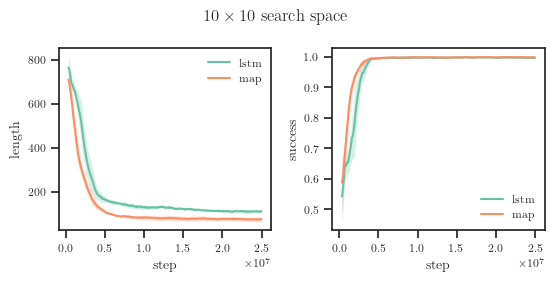

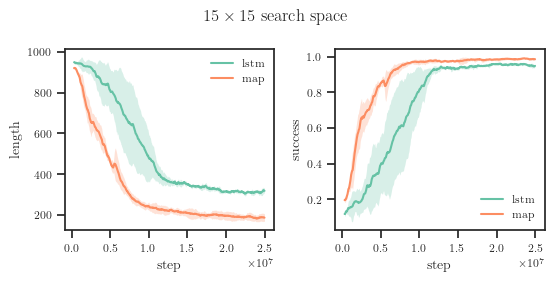

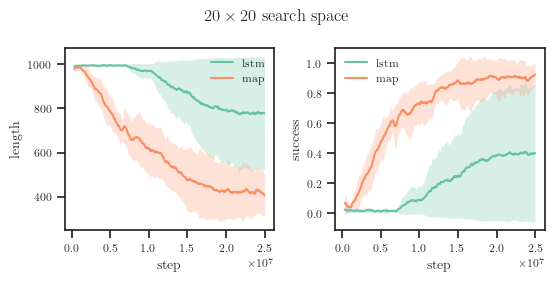

In [76]:
timesteps = int(25e6)
shapes = [10, 15, 20]
fields = ["length", "success"]
seeds = [0, 1, 2, 3]

for shape in shapes:
    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.5))

    data = {
        "lstm": [f"results/shape/lstm/{shape}/{seed}/train.csv" for seed in seeds],
        "map": [f"results/shape/map/{shape}/{seed}/train.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):
        for label, csv_files in data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.95, first_valid=20, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)
        ax.legend(frameon=False)

    fig.suptitle(fr"${shape} \times {shape}$ search space")
    fig.tight_layout()
    fig.savefig(figpath(f"shape-{shape}"))

### Samples

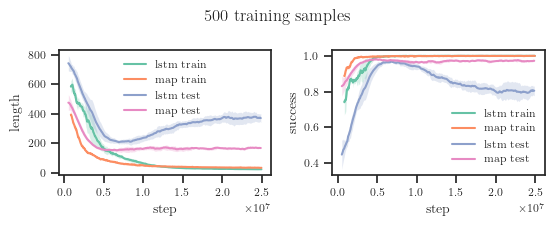

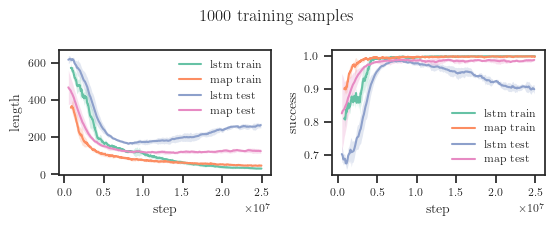

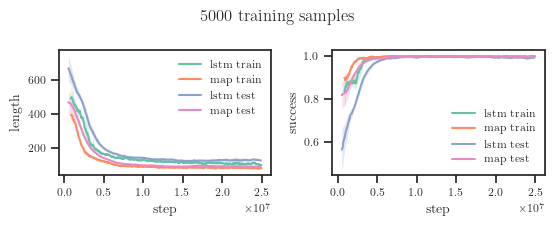

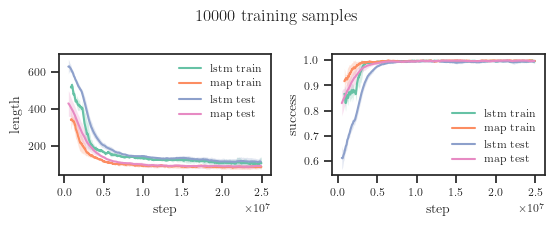

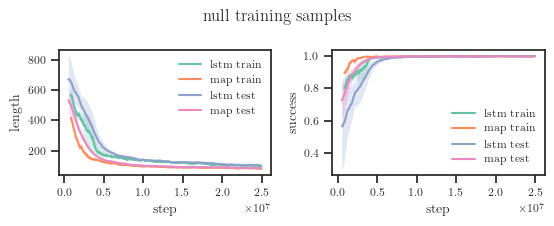

In [78]:
timesteps = int(25e6)
fields = ["length", "success"]
seeds = range(3)
samples = [500, 1000, 5000, 10000, "null"]

for sample in samples:
    fig, axs = plt.subplots(1, 2, figsize=figsize(width=TEXTWIDTH_IN, ratio=0.4))

    train_data = {
        "lstm train": [f"results/sample/lstm/{sample}/{seed}/train.csv" for seed in seeds],
        "map train": [f"results/sample/map/{sample}/{seed}/train.csv" for seed in seeds],
    }

    test_data = {
        "lstm test": [f"results/sample/lstm/{sample}/{seed}/test.csv" for seed in seeds],
        "map test": [f"results/sample/map/{sample}/{seed}/test.csv" for seed in seeds],
    }

    for ax, field in zip(axs, fields):

        for label, csv_files in train_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=50, x_scale=timesteps/raw_data.shape[1])

        for label, csv_files in test_data.items():
            raw_data = np.array([read_csv(f, field) for f in csv_files])
            plot_values(ax, raw_data, label=label, smoothing=0.9, first_valid=5, x_scale=timesteps/raw_data.shape[1])

        ax.set_xlabel("step")
        ax.set_ylabel(field)
        ax.legend(frameon=False)

    fig.suptitle(fr"{sample} training samples")
    fig.tight_layout()
    fig.savefig(figpath(f"sample-{sample}"))

## Extra

### Tensorboard

In [108]:
from glob import glob
from scipy import stats
from functools import lru_cache
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator, STORE_EVERYTHING_SIZE_GUIDANCE


def load_scalars(events, tag):
    event_acc = EventAccumulator(events, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
    event_acc.Reload()
    scalars = event_acc.Scalars(tag)
    df = pd.DataFrame(scalars)
    return df


def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

### Latent Images

In [1]:
import torch as th
import numpy as np
from sklearn.decomposition import PCA

import rl
import gym
import gym_search

def image_decomposition(x):
    h, w, c = x.shape
    if c == 3: return x
    x = x.flatten().reshape(h*w, c)
    pca = PCA(n_components=3).fit(x)
    y = pca.transform(x)
    img = y.reshape(h, w, 3)
    img *= (255.0/img.max())
    return np.abs(img)

#device = th.device("cpu")
#envs = gym.vector.make("Terrain-v0", num_envs=1)
#agent = th.load("models/baseline-small.pt").to(device)
#obs = envs.reset()